In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import sklearn
import math

In [2]:
results_df_raw = pd.read_parquet("Data/results_first_move_evaluated_full.parquet", engine='fastparquet')
results_df_raw.head()

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,...,transformer_moves_correct_top5,total_puzzle_moves,cnn_puzzle_pct,cnn_puzzle_pct_top3,cnn_puzzle_pct_top5,transformer_puzzle_pct,transformer_puzzle_pct_top3,transformer_puzzle_pct_top5,cnn_puzzle_complete,transformer_puzzle_complete
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1877,76,95,8786,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,None,...,3,3,100.0,100.0,100.0,100.0,100.0,100.0,1,1
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1501,73,96,35000,advantage endgame short,https://lichess.org/F8M8OS71#53,None,...,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0008Q,8/4R3/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 w - - 1 64,e7f7 f5e5 e2f1 e5e6,1355,76,91,743,advantage endgame rookEndgame short,https://lichess.org/MQSyb3KW#127,None,...,2,2,100.0,100.0,100.0,100.0,100.0,100.0,1,1
3,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...,b6c5 e2g4 h3g4 d1g4,1103,74,88,603,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...,...,2,2,100.0,100.0,100.0,100.0,100.0,100.0,1,1
4,000Pw,6k1/5p1p/4p3/4q3/3nN3/2Q3P1/PP3P1P/6K1 w - - 2 37,e4d2 d4e2 g1f1 e2c3,1422,74,92,604,crushing endgame fork short,https://lichess.org/au2lCK5o#73,None,...,2,2,0.0,0.0,100.0,0.0,100.0,100.0,0,0



Puzzles 100% Solved: CNN 53.70% | Transformer 59.99%


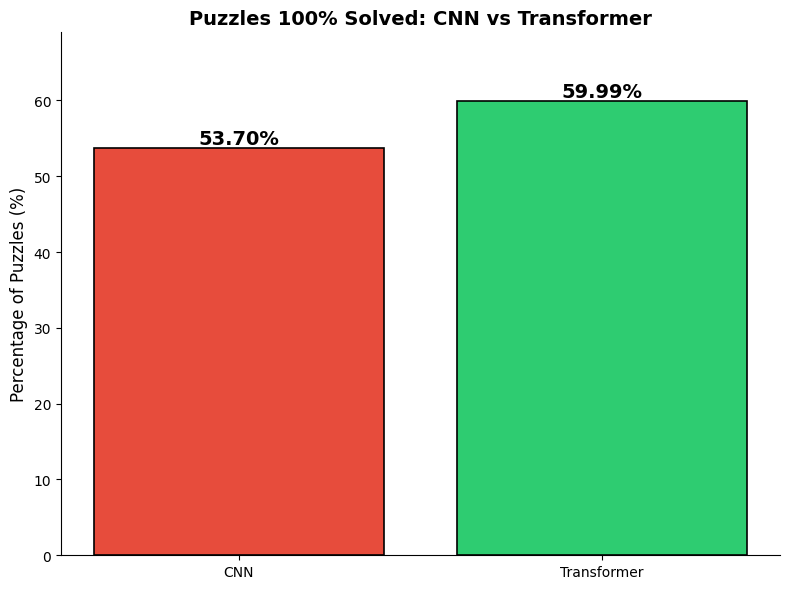

In [3]:
# Percentage of puzzles that were 100% solved (all moves correct)
cnn_fully_solved = results_df_raw['cnn_puzzle_complete'].mean() * 100
transformer_fully_solved = results_df_raw['transformer_puzzle_complete'].mean() * 100
print(f"\nPuzzles 100% Solved: CNN {cnn_fully_solved:.2f}% | Transformer {transformer_fully_solved:.2f}%")

# Create comparison bar plot showing aggregate accuracies
fig, ax = plt.subplots(figsize=(8, 6))

models = ['CNN', 'Transformer']
accuracies = [cnn_fully_solved, transformer_fully_solved]
colors = ['#e74c3c','#2ecc71']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
ax.set_ylabel('Percentage of Puzzles (%)', fontsize=12)
ax.set_title('Puzzles 100% Solved: CNN vs Transformer', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(accuracies) * 1.15)  # Add space for labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [4]:
# Check in results dataset
missing = False
for col in results_df_raw.columns:
    missing_values = results_df_raw[col].isnull().sum()
    if missing_values > 0:
        print(f"Column '{col}' has {missing_values} missing values.")
        missing = True

if missing:
    print("Missing values found in the results dataset.")
else:
    print("No missing values found in the results dataset.")

# Check for duplicate PuzzleId values
dup_mask = results_df_raw['PuzzleId'].duplicated(keep=False) 
n_dup_rows = dup_mask.sum()
n_dup_ids = results_df_raw.loc[dup_mask, 'PuzzleId'].nunique()

if n_dup_ids == 0:
    print("No duplicate PuzzleId values found.")
else:
    print(f"Rows with duplicated PuzzleId: {n_dup_rows:,}")
    print(f"Unique PuzzleId values that are duplicated: {n_dup_ids:,}")

Column 'OpeningTags' has 4471771 missing values.
Missing values found in the results dataset.
No duplicate PuzzleId values found.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cols = ['Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'total_puzzle_moves']

# --- 1) Basic sanity checks ---
print("Summary statistics for numeric columns:")
display(results_df_raw[cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

def visualize_outliers(df, columns, dataset_name):
    """
    Plots a Boxplot (left) and Histogram (right) for each column.
    """
    sns.set_style("whitegrid")
    
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # --- Plot 1: Boxplot (Horizontal) ---
        sns.boxplot(x=df[col], ax=axes[0], color='skyblue')
        axes[0].set_title(f'Boxplot: {col} (Outlier Check)')
        
        # --- Plot 2: Histogram ---
        # We use a log scale for the histogram if the data is massive (like NbPlays)
        # This allows you to actually SEE the distribution instead of just one bar.
        if df[col].max() > 10000 and df[col].min() >= 0:
            sns.histplot(df[col], ax=axes[1], color='salmon', bins=50, log_scale=True)
            axes[1].set_title(f'Histogram: {col} (Log Scale)')
        else:
            sns.histplot(df[col], ax=axes[1], color='salmon', bins=50, kde=True)
            axes[1].set_title(f'Histogram: {col}')
            
        plt.suptitle(f'{dataset_name}: {col}', fontsize=14)
        plt.show()

# --- EXECUTE VISUALIZATION ---

# 1. Visualize Puzzles
print("--- Visualizing Puzzles Dataset ---")
visualize_outliers(results_df_raw, ['Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'total_puzzle_moves'], "Puzzles")

Summary statistics for numeric columns:


MemoryError: Unable to allocate 42.7 MiB for an array with shape (5600086,) and data type float64

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

def perform_mcnemar_test(df, cnn_col, transformer_col, test_name):
    """
    Perform McNemar's test to compare CNN vs Transformer on paired binary outcomes.
    
    Contingency table:
                    Transformer Correct | Transformer Wrong
    CNN Correct     |       a           |        b
    CNN Wrong       |       c           |        d
    """
    # Remove rows with missing values
    df_clean = df[[cnn_col, transformer_col]].dropna()
    
    # Create contingency table
    both_correct = ((df_clean[cnn_col] == 1) & (df_clean[transformer_col] == 1)).sum()
    cnn_only = ((df_clean[cnn_col] == 1) & (df_clean[transformer_col] == 0)).sum()
    transformer_only = ((df_clean[cnn_col] == 0) & (df_clean[transformer_col] == 1)).sum()
    both_wrong = ((df_clean[cnn_col] == 0) & (df_clean[transformer_col] == 0)).sum()
    
    # Build 2x2 table
    table = [[both_correct, cnn_only],
             [transformer_only, both_wrong]]
    
    print(f"\n{'='*60}")
    print(f"McNemar's Test: {test_name}")
    print(f"{'='*60}")
    print(f"Sample size: {len(df_clean):,}")
    print(f"\nContingency Table:")
    print(f"                    Transformer Correct | Transformer Wrong")
    print(f"CNN Correct     |    {both_correct:>10,}      |   {cnn_only:>10,}")
    print(f"CNN Wrong       |    {transformer_only:>10,}      |   {both_wrong:>10,}")
    
    # Perform McNemar's test
    result = mcnemar(table, exact=False, correction=True)
    
    print(f"\nTest Statistic (χ²): {result.statistic:.4f}")
    print(f"P-value: {result.pvalue}")
    
    if result.pvalue < 0.001:
        print("Result: *** Highly significant difference (p < 0.001)")
    elif result.pvalue < 0.01:
        print("Result: ** Significant difference (p < 0.01)")
    elif result.pvalue < 0.05:
        print("Result: * Significant difference (p < 0.05)")
    else:
        print("Result: No significant difference (p ≥ 0.05)")
    
    # Interpretation
    if transformer_only > cnn_only:
        print(f"Interpretation: Transformer outperforms CNN ({transformer_only:,} vs {cnn_only:,})")
    elif cnn_only > transformer_only:
        print(f"Interpretation: CNN outperforms Transformer ({cnn_only:,} vs {transformer_only:,})")
    else:
        print("Interpretation: Models perform equally")
    
    return result

# Perform tests on different metrics
perform_mcnemar_test(results_df_raw, 'cnn_first_move_correct', 'transformer_first_move_correct', 
                     'First Move (Exact)')

perform_mcnemar_test(results_df_raw, 'cnn_puzzle_complete', 'transformer_puzzle_complete', 
                     'Full Puzzle Complete')

In [ ]:
# Create Rating Bins (e.g., 600-800, 800-1000...)
results_df_raw['rating_bin'] = pd.cut(results_df_raw['Rating'], bins=range(600, 3000, 200))

# Calculate Accuracy per Bin and count puzzles
bin_analysis = results_df_raw.groupby('rating_bin', observed=True).agg({
    'cnn_puzzle_complete': 'mean',
    'transformer_puzzle_complete': 'mean',
    'PuzzleId': 'count'  # Count puzzles per bin
}).reset_index()
bin_analysis.rename(columns={'PuzzleId': 'puzzle_count'}, inplace=True)

# Calculate the Gap
bin_analysis['Gap (Trans - CNN)'] = bin_analysis['transformer_puzzle_complete'] - bin_analysis['cnn_puzzle_complete']

# Visualization with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary axis: Accuracy lines
ax1.plot(bin_analysis['rating_bin'].astype(str), bin_analysis['cnn_puzzle_complete'], 
         marker='o', label='CNN', color='red', linewidth=2, markersize=8)
ax1.plot(bin_analysis['rating_bin'].astype(str), bin_analysis['transformer_puzzle_complete'], 
         marker='o', label='Transformer', color='blue', linewidth=2, markersize=8)

ax1.set_xlabel('Rating Range', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Secondary axis: Puzzle counts
ax2 = ax1.twinx()
ax2.bar(bin_analysis['rating_bin'].astype(str), bin_analysis['puzzle_count'], 
        alpha=0.3, color='gray', label='Puzzle Count')
ax2.set_ylabel('Number of Puzzles', fontsize=12)
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Accuracy by Puzzle Rating with Sample Sizes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the table to find the smallest gap
print("\nAccuracy and Puzzle Counts by Rating:")
display(bin_analysis)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Select only necessary columns BEFORE exploding (critical for memory efficiency)
subset_df = results_df_raw[['PuzzleId', 'Themes', 'cnn_puzzle_complete', 'transformer_puzzle_complete']].copy()

# 2) Explode Themes
exploded = (
    subset_df
    .dropna(subset=["Themes"])
    .assign(Theme=subset_df["Themes"].astype(str).str.split())
    .explode("Theme")
)

# Remove empty tokens
exploded = exploded[exploded["Theme"].notna() & exploded["Theme"].ne("")]

# 3) Accuracy + support per theme
theme_stats = (
    exploded.groupby("Theme")
    .agg(
        n=("Theme", "size"),
        cnn_acc=("cnn_puzzle_complete", "mean"),
        tr_acc=("transformer_puzzle_complete", "mean"),
    )
)

theme_stats["Gap"] = theme_stats["tr_acc"] - theme_stats["cnn_acc"]

# Filter for themes with at least 500 puzzles (statistical significance)
theme_stats = theme_stats[theme_stats['n'] >= 500]

print(f"--- Themes with ≥500 puzzles: {len(theme_stats)} themes ---")
display(theme_stats.sort_values("Gap").head(20))  # Top 20 CNN-favorable themes


# 3) Plotting (all themes is unreadable). Plot Top-K by support or by gap.
TOP_K = 30

# Example A: most frequent themes (best for stability)
top_by_support = theme_stats.sort_values("n", ascending=False).head(TOP_K)

plt.figure(figsize=(12, 6))
top_by_support[["cnn_acc","tr_acc"]].plot(kind="bar", figsize=(12,6))
plt.title(f"Top {TOP_K} Most Frequent Themes: CNN vs Transformer Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Example B: where CNN is strongest (but avoid tiny-n noise: still show n)
top_cnn = theme_stats.sort_values("Gap").head(TOP_K)

plt.figure(figsize=(12, 6))
top_cnn[["cnn_acc","tr_acc"]].plot(kind="bar", figsize=(12,6))
plt.title(f"Top {TOP_K} Themes Most Favorable to CNN (by Gap)")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. THEME ANALYSIS (The "Specialist" Argument) ---
# Memory-efficient: Select only necessary columns BEFORE exploding
subset_df = results_df_raw[['PuzzleId', 'Themes', 'Rating', 'cnn_puzzle_complete', 'transformer_puzzle_complete']].copy()

# Explode themes to analyze them individually
exploded_themes = subset_df.dropna(subset=['Themes']).assign(Theme=subset_df['Themes'].str.split(' ')).explode('Theme')

# Filter for themes with at least 500 puzzles (to ensure statistical significance)
theme_counts = exploded_themes['Theme'].value_counts()
valid_themes = theme_counts[theme_counts > 500].index
theme_data = exploded_themes[exploded_themes['Theme'].isin(valid_themes)]

# Calculate accuracy per theme
theme_perf = theme_data.groupby('Theme')[['cnn_puzzle_complete', 'transformer_puzzle_complete']].mean()

# Calculate "CNN Advantage" (Positive means CNN wins)
theme_perf['CNN_Advantage'] = theme_perf['cnn_puzzle_complete'] - theme_perf['transformer_puzzle_complete']

# Get the top 10 themes where CNN is strongest
cnn_favorites = theme_perf.sort_values('CNN_Advantage', ascending=False).head(10)

print("--- Themes where CNN Outperforms Transformer ---")
display(cnn_favorites)

# Visualization 1: CNN's Strongest Themes
plt.figure(figsize=(10, 6))
sns.barplot(x=cnn_favorites['CNN_Advantage'], y=cnn_favorites.index, palette='Reds_r')
plt.axvline(0, color='black', linewidth=1)
plt.title('The "Specialist": Themes where CNN Beats the Transformer', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy Advantage (CNN - Transformer)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. RATING ANALYSIS (The "Complexity" Argument) ---
# Use full dataframe for rating analysis (already done in previous cell)
# Skipping to avoid duplication

# --- 3. REVENGE ANALYSIS (The "Blind Spot" Argument) ---
# Isolate puzzles where CNN is RIGHT and Transformer is WRONG
revenge_df = results_df_raw[(results_df_raw['cnn_puzzle_complete'] == 1) & 
                             (results_df_raw['transformer_puzzle_complete'] == 0)]

print(f"\nCNN 'Revenge' Count: {len(revenge_df):,} puzzles")
print(f"Avg Rating of Revenge Puzzles: {revenge_df['Rating'].mean():.0f}")
print(f"Global Avg Rating: {results_df_raw['Rating'].mean():.0f}")

# Visualization 3: Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.kdeplot(revenge_df['Rating'], fill=True, color='red', label='CNN Wins / Trans Loses', alpha=0.3)
sns.kdeplot(results_df_raw['Rating'], linestyle='--', color='gray', label='All Puzzles')
plt.title('Where does the Transformer Fail? (Rating Distribution)', fontsize=14, fontweight='bold')
plt.xlabel('Puzzle Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build/ensure puzzle solution length ---
# Uses "solution_len" if you already made it; otherwise compute from Moves
if "solution_len" not in results_df_raw.columns:
    results_df_raw["solution_len"] = results_df_raw["Moves"].fillna("").astype(str).str.split().str.len()

# Define bins (tweak as you like)
bins = [0, 2, 4, 6, 10, 1000]
labels = ["1-2", "3-4", "5-6", "7-10", "11+"]

results_df_raw["puzzle_len_bin"] = pd.cut(results_df_raw["solution_len"], bins=bins, labels=labels)

# Aggregate
puz = (results_df_raw.groupby("puzzle_len_bin", observed=True)
       .agg(n=("solution_len", "size"),
            cnn_acc=("cnn_puzzle_complete", "mean"),
            tr_acc=("transformer_puzzle_complete", "mean"))
       .assign(gap=lambda t: t["tr_acc"] - t["cnn_acc"]))

display(puz)

# Plot accuracies
plt.figure(figsize=(10,5))
plt.plot(puz.index.astype(str), puz["cnn_acc"], marker="o", label="CNN", linewidth=2, color='red')
plt.plot(puz.index.astype(str), puz["tr_acc"], marker="o", label="Transformer", linewidth=2, color='blue')
plt.title("Accuracy by Puzzle Solution Length", fontsize=14, fontweight='bold')
plt.xlabel("Number of Moves in Solution")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot gap (TR - CNN)
plt.figure(figsize=(10,5))
plt.plot(puz.index.astype(str), puz["gap"], marker="o", label="Transformer - CNN", linewidth=2, color='green')
plt.axhline(0, linestyle="--", color='black', alpha=0.5)
plt.title("Accuracy Gap by Puzzle Solution Length", fontsize=14, fontweight='bold')
plt.xlabel("Number of Moves in Solution")
plt.ylabel("Accuracy Gap (Transformer - CNN)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()